In [4]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import year
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import seaborn as sns


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 15:10:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:

# Spark Load Dataset
df = spark.read.csv('Datasets/worldriskindex.csv', inferSchema=True, header=True)

df2 = spark.read.csv('Datasets/prevalence.csv', inferSchema=True, header=True)

df3 = spark.read.csv('Datasets/poverty-share-on-less-than-30-per-day.csv', inferSchema=True, header=True)

df4 = spark.read.csv('Datasets/yielddf.csv', inferSchema=True, header=True)

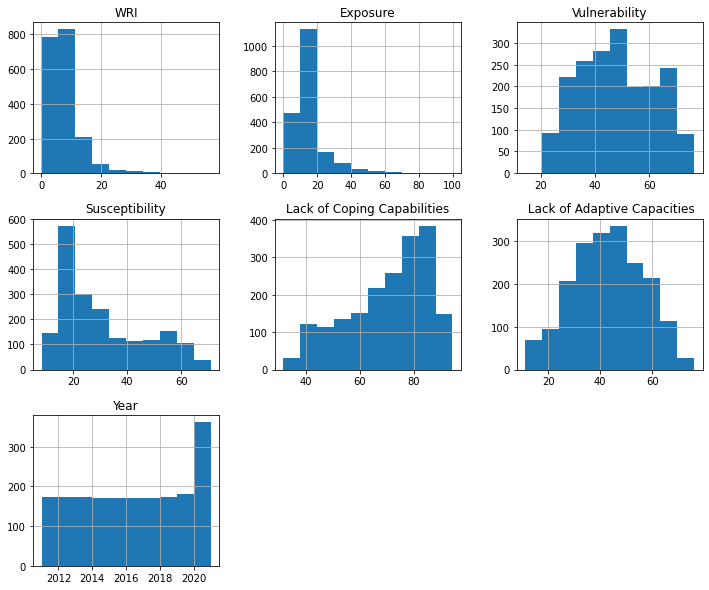

In [7]:
pandas_df = df.toPandas()
pandas_df.hist(figsize=(12, 10))
plt.show()



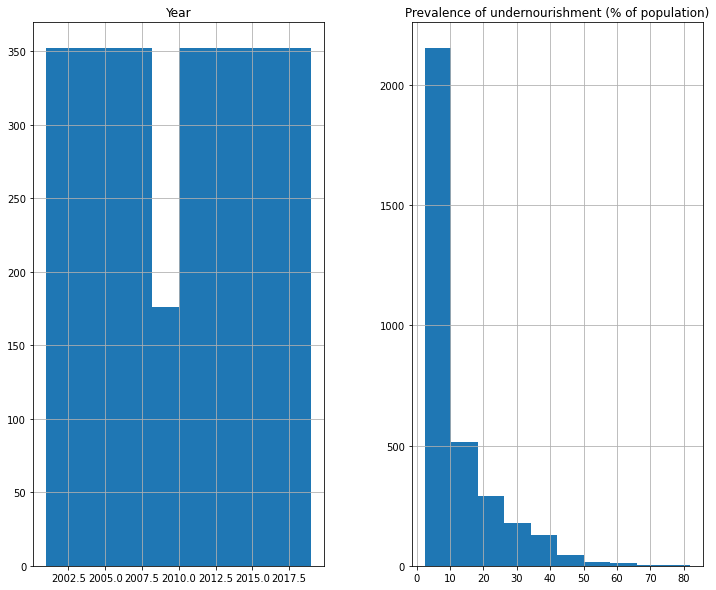

In [8]:
pandas_df = df2.toPandas()
pandas_df.hist(figsize=(12, 10))
plt.show()

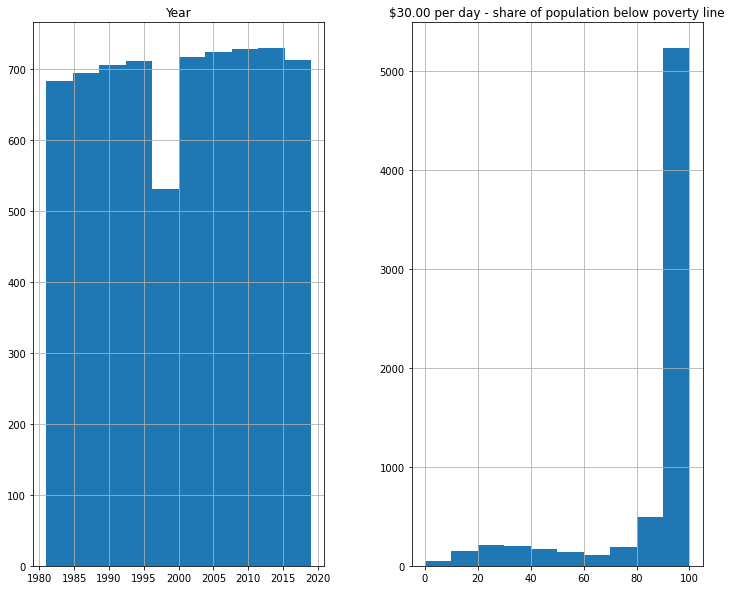

In [9]:
pandas_df = df3.toPandas()
pandas_df.hist(figsize=(12, 10))
plt.show()

23/10/11 15:16:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/aws-instance-fork/Datasets/yielddf.csv


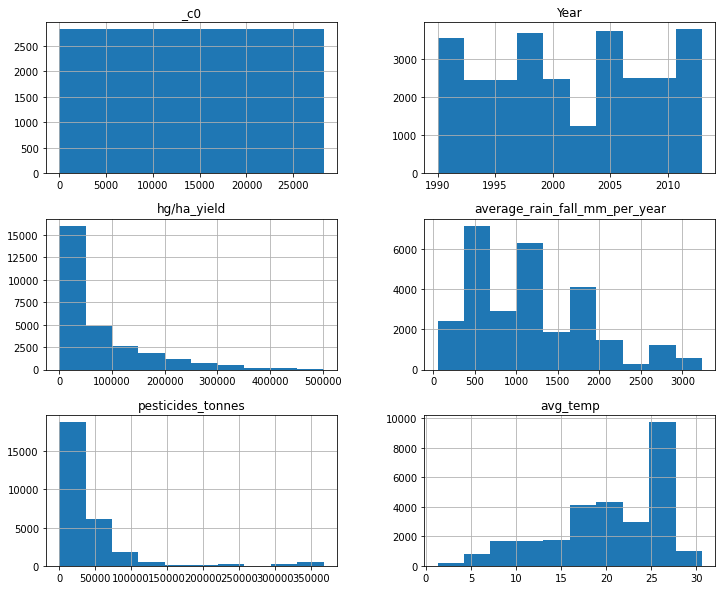

In [10]:
pandas_df = df4.toPandas()
pandas_df.hist(figsize=(12, 10))
plt.show()

In [ ]:
# pandas 
file1 = 'Datasets/worldriskindex.csv'

file2 = 'Datasets/prevalence.csv'

file3 = 'Datasets/poverty-share-on-less-than-30-per-day.csv'

file4 = 'Datasets/yielddf.csv'

df = pd.read_csv(file1)

df2 = pd.read_csv(file2)

df3 = pd.read_csv(file3)

df4 = pd.read_csv(file4)

In [ ]:
df.show()

In [ ]:
df2.show()

In [ ]:
df3.show()

In [ ]:
df4.show()

In [ ]:
# Explore Data

df.describe().show()

In [ ]:
df2.describe().show()

In [ ]:
df3.describe().show()

In [ ]:
df4.describe().show()

In [ ]:
sns.displot(df['WRI'])


In [ ]:
sns.displot(df2['Prevalence of undernourishment (% of population)'])


In [ ]:
sns.displot(df3['$30.00 per day - share of population below poverty line'])


In [ ]:
sns.displot(df4['hg/ha_yield'])

In [3]:
df_filtered = df[df['Year'] == 2013]
df_filtered2 = df2[df2['Year'] == 2013]
df_filtered3 = df3[df3['Year'] == 2013]
df_filtered4 = df4[df4['Year'] == 2013]

In [ ]:
df_filtered.show()

In [ ]:
df_filtered2.show()

In [ ]:
df_filtered3.show()

In [ ]:
df_filtered4.show()

In [ ]:
def classify_poverty_level(value):
    if value > 90:
        return 'extreme poor'
    elif 70 <= value <= 90:
        return 'very poor'
    elif 50 <= value < 70:
        return 'poor'
    else:
        return 'not poor'

In [ ]:
df3['Poverty Level'] = df3['$30.00 per day - share of population below poverty line'].apply(classify_poverty_level)

In [ ]:
df3

In [4]:
df2_renamed = df2.withColumnRenamed("Entity","Region")
df2_renamed.show()

df3_renamed = df3.withColumnRenamed("Entity","Region")
df3_renamed.show()

df4_renamed = df4.withColumnRenamed("Area","Region")
df4_renamed.show()

+-----------+----+----+------------------------------------------------+
|     Region|Code|Year|Prevalence of undernourishment (% of population)|
+-----------+----+----+------------------------------------------------+
|Afghanistan| AFG|2001|                               47.79999923706055|
|Afghanistan| AFG|2002|                              45.599998474121094|
|Afghanistan| AFG|2003|                              40.599998474121094|
|Afghanistan| AFG|2004|                                            38.0|
|Afghanistan| AFG|2005|                              36.099998474121094|
|Afghanistan| AFG|2006|                               33.29999923706055|
|Afghanistan| AFG|2007|                              29.799999237060547|
|Afghanistan| AFG|2008|                                            26.5|
|Afghanistan| AFG|2009|                              24.399999618530273|
|Afghanistan| AFG|2010|                              23.700000762939453|
|Afghanistan| AFG|2011|                            

23/10/11 09:30:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/aws-instance-fork/Datasets/yielddf.csv


In [5]:
#spark merge

df2_renamed = df_filtered2.withColumnRenamed("Entity","Region")
df3_renamed = df_filtered3.withColumnRenamed("Entity","Region")
df4_renamed = df_filtered4.withColumnRenamed("Area","Region")



merged_df = df_filtered.join(df2_renamed, on=["Region", "Year"], how="inner")

merged_df = merged_df.join(df3_renamed, on=["Region", "Year"], how="inner")
merged_df = merged_df.join(df4_renamed, on=["Region", "Year"], how="inner")



merged_df.show()

23/10/11 09:30:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/aws-instance-fork/Datasets/yielddf.csv


+-----------+----+-----+--------+-------------+--------------+---------------------------+----------------------------+-----------------+------------+----------------------+-----------------------+----+------------------------------------------------+----+-------------------------------------------------------+-----+--------------------+-----------+-----------------------------+-----------------+--------+
|     Region|Year|  WRI|Exposure|Vulnerability|Susceptibility|Lack of Coping Capabilities| Lack of Adaptive Capacities|Exposure Category|WRI Category|Vulnerability Category|Susceptibility Category|Code|Prevalence of undernourishment (% of population)|Code|$30.00 per day - share of population below poverty line|  _c0|                Item|hg/ha_yield|average_rain_fall_mm_per_year|pesticides_tonnes|avg_temp|
+-----------+----+-----+--------+-------------+--------------+---------------------------+----------------------------+-----------------+------------+----------------------+---------

In [ ]:
#pandas merge 


In [6]:
merged_df = merged_df.withColumnRenamed("$30.00 per day - share of population below poverty line","poverty")
merged_df = merged_df.withColumnRenamed("Prevalence of undernourishment (% of population)","Prevalence")
merged_df = merged_df.withColumnRenamed("average_rain_fall_mm_per_year","aver_rain")
merged_df = merged_df.withColumnRenamed("pesticides_tonnes","Ptonnes")

merged_df = merged_df.drop("Exposure","Vulnerability","Susceptibility","Lack of Coping Capabilities",
                           "Exposure Category","Vulnerability Category","Susceptibility Category"," Lack of Adaptive Capacities","Code"
                          ,"_c0","Item")

merged_df = merged_df.fillna(0)


merged_df.show()

+------------+----+-----+------------+------------------+-----------------+-----------+---------+-------+--------+
|      Region|Year|  WRI|WRI Category|        Prevalence|          poverty|hg/ha_yield|aver_rain|Ptonnes|avg_temp|
+------------+----+-----+------------+------------------+-----------------+-----------+---------+-------+--------+
|      Angola|2013| 6.48|      Medium|              15.0|          99.6171|       9022|   1010.0|   40.0|   24.55|
|      Angola|2013| 6.48|      Medium|              15.0|          99.6171|      73409|   1010.0|   40.0|   24.55|
|      Angola|2013| 6.48|      Medium|              15.0|          99.6171|       4405|   1010.0|   40.0|   24.55|
|      Angola|2013| 6.48|      Medium|              15.0|          99.6171|       2415|   1010.0|   40.0|   24.55|
|      Angola|2013| 6.48|      Medium|              15.0|          99.6171|      12744|   1010.0|   40.0|   24.55|
|      Angola|2013| 6.48|      Medium|              15.0|          99.6171|     

In [ ]:

df_numeric = merged_df.drop("Region", "WRI Category")

In [ ]:

correlation_matrix = []
for i in df_numeric.columns:
    row = []
    for j in df_numeric.columns:
        row.append(df_numeric.stat.corr(i, j))
    correlation_matrix.append(row)


correlation_df = pd.DataFrame(correlation_matrix, columns=df_numeric.columns, index=df_numeric.columns)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True)
plt.show()

In [ ]:
df_numeric_up = merged_df.drop("Region", "WRI Category","Year", "aver_rain","avg_temp")


In [ ]:
correlation_matrix = []
for i in df_numeric_up.columns:
    row = []
    for j in df_numeric_up.columns:
        row.append(df_numeric_up.stat.corr(i, j))
    correlation_matrix.append(row)


correlation_df = pd.DataFrame(correlation_matrix, columns=df_numeric_up.columns, index=df_numeric_up.columns)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True)
plt.show()

In [ ]:
# import log function
from pyspark.sql.functions import log



# applie log 
df = df.withColumn("Log_WRI", log(df["WRI"]))

# to Pandas DataFrame to visulise
dff = df.toPandas()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#  WRI 
ax[0].hist(dff['WRI'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Original WRI Data')
ax[0].set_xlabel('WRI')
ax[0].set_ylabel('Frequency')

# Log-transformed WRI 
ax[1].hist(dff['Log_WRI'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Log-transformed WRI Data')
ax[1].set_xlabel('Log(WRI)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:




#  VectorAssembler 
assembler = VectorAssembler(
    inputCols=['WRI', 'poverty', 'Ptonnes'],
    outputCol="features"
)
merged_df = assembler.transform(merged_df)

# train and test
train_data, test_data = merged_df.randomSplit([0.8, 0.2], seed=42)

# LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="Prevalence")
model = lr.fit(train_data)

# predictions
predictions = model.transform(test_data)

# mse
evaluator = RegressionEvaluator(
    labelCol="Prevalence", 
    predictionCol="prediction", 
    metricName="mse"
)
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error: {mse}")

# print Coefficients and Intercept
print(f"Coefficients: {model.coefficients}")
print(f"Intercept: {model.intercept}")


In [ ]:
#  VectorAssembler 
assembler = VectorAssembler(
    inputCols=['WRI', 'poverty', 'Ptonnes'],
    outputCol="features"
)
merged_df = assembler.transform(merged_df)

# train and test
train_data, test_data = merged_df.randomSplit([0.7, 0.3], seed=42)

# LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="Prevalence")
model = lr.fit(train_data)

# predictions
predictions = model.transform(test_data)

# mse
evaluator = RegressionEvaluator(
    labelCol="Prevalence", 
    predictionCol="prediction", 
    metricName="mse"
)

train_data.describe().show()
test_data.describe().show()
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error: {mse}")

# print Coefficients and Intercept
print(f"Coefficients: {model.coefficients}")
print(f"Intercept: {model.intercept}")

In [ ]:
from pyspark.sql.functions import mean, stddev, col


merged_df.select(mean(col("Prevalence")), stddev(col("Prevalence"))).show()


In [ ]:
import matplotlib.pyplot as plt
#  VectorAssembler 
assembler = VectorAssembler(
    inputCols=['WRI', 'poverty', 'Ptonnes'],
    outputCol="features"
)
merged_df = assembler.transform(merged_df)

# train and test
train_data, test_data = merged_df.randomSplit([0.7, 0.3], seed=42)

# LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="Prevalence")
model = lr.fit(train_data)

# predictions
predictions = model.transform(test_data)

# mse
evaluator = RegressionEvaluator(
    labelCol="Prevalence", 
    predictionCol="prediction", 
    metricName="mse"
)

train_data.describe().show()
test_data.describe().show()
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error: {mse}")

# print Coefficients and Intercept
print(f"Coefficients: {model.coefficients}")
print(f"Intercept: {model.intercept}")

coefficients = model.coefficients
features = ['WRI', 'poverty', 'Ptonnes']

# create a bar graph
plt.bar(features, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()



In [ ]:
import matplotlib.pyplot as plt


histogram_data = merged_df.select('poverty').rdd.flatMap(lambda x: x).histogram(100)


bins = histogram_data[0]
freq = histogram_data[1]


plt.bar(bins[:-1], freq, width=(bins[1] - bins[0]))
plt.title('Distribution of Economic Indicator')
plt.xlabel('poverty')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import matplotlib.pyplot as plt


coefficients = model.coefficients


features = ['poverty',
            'Prevalence', 'WRI']

plt.bar(features, coefficients)
plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)  # rotate x for better understanding
plt.tight_layout()


plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 
pdf = predictions.select("Prevalence", "prediction").toPandas()

# 
plt.scatter(pdf["Prevalence"], pdf["prediction"])
plt.plot([pdf["Prevalence"].min(), pdf["Prevalence"].max()], [pdf["Prevalence"].min(), pdf["Prevalence"].max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Hunger Index')
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import log1p

# train and test
train_data, test_data = merged_df.randomSplit([0.7, 0.3], seed=42)

train_data = train_data.withColumn("WRI", log1p(train_data["WRI"]))


assembler = VectorAssembler(inputCols=["WRI"], outputCol="features")
X_train_transformed = assembler.transform(train_data)


lr = LinearRegression(featuresCol="features", labelCol="Prevalence", regParam=1.0, elasticNetParam=0)  # regParam corresponds to alpha, elasticNetParam=0 means Ridge regression
model = lr.fit(X_train_transformed)


X_test_transformed = assembler.transform(test_data)
predictions = model.transform(X_test_transformed)


evaluator = RegressionEvaluator(labelCol="Prevalence", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(f"iteration 2 MSE: {mse}")


In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# train and test
train_data, test_data = merged_df.randomSplit([0.7, 0.3], seed=42)


label_column = "Prevalence"


assembler = VectorAssembler(inputCols=["WRI", "poverty", "Ptonnes"], outputCol="features")
X_train_transformed = assembler.transform(train_data)


rf = RandomForestRegressor(numTrees=100, seed=42, labelCol=label_column, featuresCol="features")
model = rf.fit(X_train_transformed)


X_test_transformed = assembler.transform(test_data)
predictions = model.transform(X_test_transformed)


evaluator = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(f"iteration 3 MSE: {mse}")


iteration 3 MSE: 1.9109549239837649
